# DeepLabCut Ingestion/Inference

# DeepLabCut manual:
https://github.com/DeepLabCut/DeepLabCut/blob/main/docs/standardDeepLabCut_UserGuide.md

`Dev notes:` Currently, the path structure assumes you have one DLC project directory for all models, as specified within `adamacs.pipeline.get_dlc_root_data_dir`. The parallel function `get_dlc_processed_data_dir` can specify the output directory. 

## TODO

1. Have the DLC model as selector in the Pingest GUI (model.Model() = model_name)
2. Add a checkbox to process DLC data
3. model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True}, task_mode = 'trigger') - have additional options in table?
4. model.RecordingInfo.populate()
model.RecordingInfo()
5. model.PoseEstimation.populate()
6. defer population to tmux or cron jobs?


## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

In [41]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()

DataJoint connection (connected) tobiasr@172.26.128.53:3306

In [42]:
dj.config["custom"].get("dlc_root_data_dir")


['/datajoint-data/models/tobiasr/DB_DLC_tracking',
 '/datajoint-data/models/tobiasr/NK_DLC_tracking',
 '/']

### Imports and activation

Importing schema from `adamacs.pipeline` automatically activates items.

In [43]:
from adamacs.pipeline import subject, train,  scan, event, trial, behavior, session, model, equipment

## Ingesting videos and training parameters

### Automated

Refer the `user_data` folder in the `adamacs` directory contains CSVs for inserting values into DeepLabCut tables.

1. `config_params.csv` is used for training parameter sets in `train.TrainingParamSet`. The following items are required, but others will also be passed to DLC's `train_network` function when called 
2. `train_videosets.csv` and `model_videos.csv` pass values to `train.VideoSet` and `model.VideoRecording` respectively.
3. `adamacs.ingest.dlc.ingest_dlc_items` will load each of these CSVs

For more information, see [this notebook](https://github.com/CBroz1/workflow-deeplabcut/blob/main/notebooks/04-Automate_Optional.ipynb)

In [4]:
    # from adamacs.ingest.dlc import ingest_dlc_items
    # ingest_dlc_items()

In [5]:
model.VideoRecording().delete()
model.Model.delete()

[2023-07-28 13:13:23,666][INFO]: Deleting 0 rows from `tobiasr_model`.`video_recording`
[2023-07-28 13:13:23,667][WARNING]: Nothing to delete.
[2023-07-28 13:13:23,670][INFO]: Deleting 0 rows from `tobiasr_model`.`model`
[2023-07-28 13:13:23,670][WARNING]: Nothing to delete.


0

In [6]:
train.schema.list_tables()

['video_set',
 'video_set__file',
 '#training_param_set',
 'training_task',
 '__model_training']

In [7]:
model.schema.list_tables()

['video_recording',
 'video_recording__file',
 'model',
 'model__body_part',
 '#body_part',
 '_recording_info',
 '__model_evaluation',
 'pose_estimation_task',
 '__pose_estimation',
 '__pose_estimation__body_part_position']

### Manual

The same training parameters as above can be manually inserted as follows.

In [9]:
import yaml
from element_interface.utils import find_full_path
from adamacs.paths import get_dlc_root_data_dir
import pathlib
config_path = find_full_path(get_dlc_root_data_dir(), 
                             'from_top_tracking-DJ-2022-02-23/config.yaml')
config_path

PosixPath('/datajoint-data/models/tobiasr/DB_DLC_tracking/from_top_tracking-DJ-2022-02-23/config.yaml')

In [ ]:
model.VideoRecording.delete()

In [ ]:
scansi = "scan9FJ842C3"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4*"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 0})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [ ]:
scansi = "scan9FB2LN5C"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4*"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 1})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [ ]:
scansi = "scan9FHELAYA"
scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0] 
moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*copy*.mp4"))[0])
# moviepath = str(list(pathlib.Path((scan.ScanPath() & scan_key).fetch("path")[0]).glob("*top*.mp4-copy.mp4"))[0])

key = {'session_id': scan_key["session_id"],
       'recording_id': scan_key["scan_id"], 
       'camera': "mini2p1_top", # Currently 'scanner' due to in equipment tables
}
model.VideoRecording.insert1(key, skip_duplicates=True)
# do not include an initial `/` in relative file paths   
key.update({'file_path': moviepath,
            'file_id': 2})
model.VideoRecording.File.insert1(key, ignore_extra_fields=True, skip_duplicates=True)

In [ ]:
model.VideoRecording() * model.VideoRecording.File() * equipment.Device()

## Model Training

The `TrainingTask` table queues up training. To launch training from a different machine, one needs to edit DLC's config files to reflect updated paths. For training, this includes `dlc-models/*/*/train/pose_cfg.yaml`

`CB DEV NOTE:` I'm missing the following videos used to originally train the model:
- top_video2022-02-17T15_56_10.mp4
- top_video2022-02-21T12_18_09.mp4

#### DeepLabcut Tables

The `VideoSet` table in the `train` schema retains records of files generated in the video labeling process (e.g., `h5`, `csv`, `png`). DeepLabCut will refer to the `mat` file located under the `training-datasets` directory.

We recommend storing all paths as relative to the root in your config.

In [ ]:
train.VideoSet.delete()

In [ ]:
train.VideoSet.insert1({'video_set_id': 0}, skip_duplicates=True)
project_folder = 'from_top_tracking-DJ-2022-02-23/'
training_files = ['labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.h5',
                  'labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/CollectedData_DJ.csv',
                  'labeled-data/exp9FANLWRZ_top_video2022-02-21T12_18_09/img00674.png',
                  'videos/exp9FANLWRZ_top_video2022-02-21T12_18_09.mp4']
for idx, filename in enumerate(training_files):
    train.VideoSet.File.insert1({'video_set_id': 0,
                                 'file_id': idx,
                                 'file_path': (project_folder + filename)}, skip_duplicates=True)
train.VideoSet.File()

In [ ]:
train.VideoSet.insert1({'video_set_id': 1}, skip_duplicates=True)
project_folder = 'Head_orientation-NK-2023-07-17/'
training_files = ['labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.h5',
                  'labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/CollectedData_NK.csv',
                  'labeled-data/scan9FHF1JT7_top_video_2023-04-06T09_31_19/img00162.png',
                  'videos/scan9FHF1JT7_top_video_2023-04-06T09_31_19.mp4']
for idx, filename in enumerate(training_files):
    train.VideoSet.File.insert1({'video_set_id': 1,
                                 'file_id': idx,
                                 'file_path': (project_folder + filename)}, skip_duplicates=True)
train.VideoSet.File()

In [ ]:
train.VideoSet.delete()

The `params` longblob should be a dictionary that captures all items for DeepLabCut's `train_network` function. At minimum, this is the contents of the project's config file, as well as `suffle` and `trainingsetindex`, which are not included in the config. 

In [ ]:
from deeplabcut import train_network
help(train_network) # for more information on optional parameters

Here, we give these items, load the config contents, and overwrite some defaults, including `maxiters`, to restrict our training iterations to 5.

In [ ]:
train.TrainingParamSet()

In [ ]:
import yaml

paramset_idx = 0; paramset_desc='from_top_tracking-DJ-2022-02-23'

config_path = find_full_path(get_dlc_root_data_dir()[0], 
                             paramset_desc + '/config.yaml')

with open(config_path, 'rb') as y:
    config_params = yaml.safe_load(y)
training_params = {'shuffle': '1',
                   'trainingsetindex': '0',
                   'maxiters': '5',
                   'scorer_legacy': 'False',
                   'maxiters': '5', 
                   'multianimalproject':'False'}
config_params.update(training_params)
train.TrainingParamSet.insert_new_params(paramset_idx=paramset_idx,
                                         paramset_desc=paramset_desc,
                                         params=config_params)

In [ ]:
paramset_idx = 1; paramset_desc='Head_orientation-NK-2023-07-17'

config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')

with open(config_path, 'rb') as y:
    config_params = yaml.safe_load(y)
training_params = {'shuffle': '1',
                   'trainingsetindex': '0',
                   'maxiters': '5',
                   'scorer_legacy': 'False',
                   'maxiters': '5', 
                   'multianimalproject':'False'}
config_params.update(training_params)
train.TrainingParamSet.insert_new_params(paramset_idx=paramset_idx,
                                         paramset_desc=paramset_desc,
                                         params=config_params)

In [ ]:
config_path 

In [ ]:
train.TrainingParamSet()

In [ ]:
# train.TrainingTask.delete()

In [ ]:
key={'video_set_id': 0, 
     'paramset_idx':0,
     'training_id':0, # uniquely defines training task
     'project_path':'from_top_tracking-DJ-2022-02-23/' # relative to dlc_root in dj.config
    }
train.TrainingTask.insert1(key, skip_duplicates=True)
train.TrainingTask()

In [ ]:
key={'video_set_id': 1, 
     'paramset_idx':1,
     'training_id':1, # uniquely defines training task
     'project_path':'Head_orientation-NK-2023-07-17' # relative to dlc_root in dj.config
    }
train.TrainingTask.insert1(key, skip_duplicates=True)
train.TrainingTask()

In [ ]:
(train.TrainingParamSet & "paramset_idx=1").fetch("params")

In [ ]:
# (train.TrainingTask() & ("video_set_id = 1")).delete()
train.TrainingTask()

In [ ]:
train.ModelTraining.populate()

In [ ]:
train.ModelTraining()

To start training from a previous instance, one would need to 
[edit the relevant config file](https://github.com/DeepLabCut/DeepLabCut/issues/70) and
adjust the `maxiters` paramset (if present) to a higher threshold (e.g., 10 for 5 more itterations).
Emperical work from the Mathis team suggests 200k iterations for any true use-case.

## Tracking Joints/Body Parts

The `model` schema uses a lookup table for managing Body Parts tracked across models.

In [15]:
model.Model()

model_name User-friendly model name,task Task in the config yaml,date Date in the config yaml,iteration Iteration/version of this model,"snapshotindex which snapshot for prediction (if -1, latest)",shuffle Shuffle (1) or not (0),trainingsetindex Index of training fraction list in config.yaml,scorer Scorer/network name - DLC's GetScorerName(),config_template Dictionary of the config for analyze_videos(),project_path DLC's project_path in config relative to root,model_prefix,model_description,paramset_idx
Head_orientation-NK,Head_orientation,Jul17,0,3,1,0,DLC_resnet50_Head_orientationJul17shuffle1_90000,=BLOB=,Head_orientation-NK-2023-07-17,,"From Top, trained 5 iterations",1


In [ ]:
model.BodyPart.heading

This table is equipped with two helper functions. First, we can identify all the new body parts from a given config file.

In [ ]:
from adamacs.paths import get_dlc_root_data_dir
config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')
model.BodyPart.extract_new_body_parts(config_path)

Now, we can make a list of descriptions in the same order, and insert them into the table

In [ ]:
model.BodyPart()

In [ ]:
# Will be inserted with model insertion
# bp_desc=['Body Center', 'Head', 'Base of Tail']
# model.BodyPart.insert_from_config(config_path,bp_desc)

If we skip this step, body parts (without descriptions) will be added when we insert a model. We can [update](https://docs.datajoint.org/python/v0.13/manipulation/3-Cautious-Update.html) empty descriptions at any time.

## Declaring a Model

If training appears successful, the result can be inserted into the `Model` table for automatic evaluation.

In [ ]:
paramset_desc='from_top_tracking-DJ-2022-02-23'

config_path = find_full_path(get_dlc_root_data_dir()[0], 
                             paramset_desc + '/config.yaml')

In [ ]:
model.Model.insert_new_model(model_name='from_top_tracking-DJ',dlc_config=config_path,
                             shuffle=1,trainingsetindex=0,
                             model_description='From Top, trained 5 iterations',
                             paramset_idx=0)

In [11]:
paramset_desc='Head_orientation-NK-2023-07-17'

config_path = find_full_path(get_dlc_root_data_dir()[1], 
                             paramset_desc + '/config.yaml')

In [12]:
config_path

PosixPath('/datajoint-data/models/tobiasr/NK_DLC_tracking/Head_orientation-NK-2023-07-17/config.yaml')

In [13]:
model.Model.insert_new_model(model_name='Head_orientation-NK',dlc_config=config_path,
                             shuffle=1,trainingsetindex=0,
                             model_description='From Top, trained 5 iterations',
                             paramset_idx=1)

2023-07-28 13:14:05.739422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 13:14:05.859905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tobiasr/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-07-28 13:14:05.859926: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-28 13:14:05.890011: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already 

Loading DLC 2.3.4...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)
--- DLC Model specification to be inserted ---
	model_name: Head_orientation-NK
	model_description: From Top, trained 5 iterations
	scorer: DLC_resnet50_Head_orientationJul17shuffle1_90000
	task: Head_orientation
	date: Jul17
	iteration: 0
	snapshotindex: 3
	shuffle: 1
	trainingsetindex: 0
	project_path: Head_orientation-NK-2023-07-17
	paramset_idx: 1
	-- Template/Contents of config.yaml --
		Task: Head_orientation
		scorer: NK
		date: Jul17
		multianimalproject: False
		identity: None
		project_path: /datajoint-data/models/tobiasr/NK_DLC_tracking/Head_orientation-NK-2023-07-17
		video_sets: {'/datajoint-data/models/tobiasr/DeepLabCutModels/NK_DLC_tracking/Head_orientation-NK-2023-07-17/videos/scan9FHF1JT7_top_video_2023-04-06T09_31_19.mp4': {'crop': '0, 1000, 0, 1000'}}
		bodyparts: ['left_ear', 'right_ear', 'nose', 'head_middle', 'neck', 'body_middle', 'tail']
		start: 0
		

In [ ]:
model.Model()

In [ ]:
model.VideoRecording * model.VideoRecording.File()

In [ ]:
model.Model().fetch("config_template")

In [ ]:
model.Model.BodyPart()

## Model Evaluation

Next, all inserted models can be evaluated with a similar `populate` method, which will
insert the relevant output from DLC's `evaluate_network` function.

In [ ]:
model.ModelEvaluation.heading

In [ ]:
model.ModelEvaluation.populate()

If your project was initialized in a version of DeepLabCut other than the one you're currently using, model evaluation may report key errors. Specifically, your `config.yaml` may not specify `multianimalproject: false`.

In [ ]:
model.ModelEvaluation()

In [ ]:
model.RecordingInfo.populate()
model.RecordingInfo() * model.VideoRecording.File()

## Pose Estimation

In [16]:
scansi = "scan9FHELMRY"
scan_key = (model.VideoRecording.File & f'recording_id = "{scansi}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

array(['/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4'],
      dtype=object)

In [17]:
model.VideoRecording.File()

session_id,recording_id,file_id,"file_path filepath of video, relative to root data directory"
sess9FHELAYA,scan9FHELAYA,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELAYA_sess9FHELAYA/scan9FHELAYA_top_video_2023-04-05T15_19_53.mp4
sess9FHELAYA,scan9FHELMRY,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELMRY_sess9FHELAYA/scan9FHELMRY_top_video_2023-04-05T15_41_39.mp4
sess9FHELAYA,scan9FHELX2S,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHELX2S_sess9FHELAYA/scan9FHELX2S_top_video_2023-04-05T16_01_14.mp4
sess9FHELAYA,scan9FHEMBE2,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA/scan9FHEMBE2_top_video_2023-04-05T16_27_55.mp4


For demonstration purposes, we'll make a shorter video that will process relatively quickly `ffmpeg`, a DLC dependency ([more info here](https://github.com/datajoint/workflow-deeplabcut/blob/main/notebooks/00-DataDownload_Optional.ipynb))

In [ ]:
from adamacs.paths import get_dlc_root_data_dir
vid_path =  find_full_path(get_dlc_root_data_dir(), path[0][1::])
print(vid_path)
starttime = 0
duration = 10
cmd = (f'ffmpeg -n -hide_banner -loglevel error -ss {starttime} -t {duration} -i {vid_path} '
       + f'-vcodec copy -acodec copy {vid_path}-copy.mp4')
import os; os.system(cmd)

In [ ]:
model.VideoRecording.delete()

Next, we need to specify if the `PoseEstimation` table should load results from an existing file or trigger the estimation command. Here, we can also specify parameters accepted by the `analyze_videos` function as a dictionary. `task_mode` determines if pose estimation results should be loaded or triggered (i.e., load vs. trigger).

In [18]:
key = (model.VideoRecording & {'recording_id': 'scan9FHELMRY'}).fetch1('KEY')
key.update({'model_name': 'Head_orientation-NK', 'task_mode': 'trigger'})
key



{'session_id': 'sess9FHELAYA',
 'recording_id': 'scan9FHELMRY',
 'model_name': 'Head_orientation-NK',
 'task_mode': 'trigger'}

The `PoseEstimationTask` table queues items for pose estimation. Additional parameters are passed to DLC's `analyze_videos` function.

In [ ]:
# model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True})
model.PoseEstimationTask.insert_estimation_task(key, key["model_name"], analyze_videos_params={'save_as_csv':True, 'dynamic':(True,.5,100)}) # dynamic cropping

In [ ]:
model.RecordingInfo.populate()
model.RecordingInfo()

In [ ]:
model.PoseEstimation.populate()

In [ ]:
model.PoseEstimationTask().delete()
model.PoseEstimation().delete()

# Data Evaluation

By default, DataJoint will store the results of pose estimation in a subdirectory
>  processed_dir / videos / device_<#>_recording_<#>_model_<name>

Pulling processed_dir from `get_dlc_processed_dir`, and device/recording information 
from the `VideoRecording` table. The model name is taken from the primary key of the
`Model` table, with spaced replaced by hyphens.
    
We can get this estimation directly as a pandas dataframe.

In [ ]:
model.PoseEstimation.BodyPartPosition() 

In [33]:
scansi = "scan9FHEMBE2"
scan_key = (model.PoseEstimation & f'recording_id = "{scansi}"').fetch('KEY')[0] 
path = (model.VideoRecording.File & scan_key).fetch("file_path")
path

array(['/datajoint-data/data/tobiasr/RN_OPI-1681_2023-04-05_scan9FHEMBE2_sess9FHELAYA/scan9FHEMBE2_top_video_2023-04-05T16_27_55.mp4'],
      dtype=object)

In [34]:
model.PoseEstimation.get_trajectory(scan_key)

scorer    Head_orientation-NK                                           
bodyparts         body_middle                             head_middle   
coords                      x           y    z likelihood           x   
0                  745.459996  209.744970  0.0   0.998801  751.617403  \
1                  747.307126  211.060556  0.0   0.999322  752.194047   
2                  747.509318  208.389225  0.0   0.999156  748.915692   
3                  747.598454  207.674765  0.0   0.999195  750.146762   
4                  745.656749  208.704544  0.0   0.998743  752.265690   
...                       ...         ...  ...        ...         ...   
36157               64.603538  594.751424  0.0   0.996413   52.734214   
36158               62.602717  584.324163  0.0   0.994625   51.530528   
36159               65.883338  578.215715  0.0   0.998203   62.226259   
36160               66.085530  575.695768  0.0   0.998815   51.563410   
36161               66.325725  573.702362  0.0   0.998782   55.686486   

scorer                                                         ...        
bodyparts                                left_ear              ... nose   
coords              y    z likelihood           x           y  ...    z   
0          147.278017  0.0   0.490887  737.544614  158.392854  ...  0.0  \
1          140.271247  0.0   0.562217  741.008309  153.504393  ...  0.0   
2          133.838680  0.0   0.526031  743.300418  148.665397  ...  0.0   
3          132.482215  0.0   0.421682  743.550037  146.859050  ...  0.0   
4          138.700433  0.0   0.526222  743.529719  147.494103  ...  0.0   
...               ...  ...        ...         ...         ...  ...  ...   
36157      533.376474  0.0   0.037491   42.038039  542.462472  ...  0.0   
36158      530.976524  0.0   0.020619   40.389605  538.187469  ...  0.0   
36159      521.187681  0.0   0.019917   43.537145  529.842040  ...  0.0   
36160      515.918541  0.0   0.042136   39.869446  523.172493  ...  0.0   
36161      516.206708  0.0   0.021607   39.337819  519.599678  ...  0.0   

scorer                                                                     
bodyparts              right_ear                                    tail   
coords    likelihood           x           y    z likelihood           x   
0           0.011321  770.873584  164.483476  0.0   0.628906  739.245826  \
1           0.016936  774.738281  169.667059  0.0   0.767599  742.113071   
2           0.016886  774.318081  162.580032  0.0   0.654310  741.562949   
3           0.017063  776.988365  167.727417  0.0   0.820400  741.603793   
4           0.032459  776.893035  167.360257  0.0   0.772014  739.719288   
...              ...         ...         ...  ...        ...         ...   
36157       0.006704   76.512394  552.194349  0.0   0.329966   73.609529   
36158       0.008732   74.492321  541.870349  0.0   0.399441   71.653876   
36159       0.139374   76.746845  533.414047  0.0   0.356807   76.734001   
36160       0.038698   75.065753  527.166493  0.0   0.324138   73.854273   
36161       0.063716   75.707243  524.017897  0.0   0.223959   72.290892   

scorer                                 
bodyparts                              
coords              y    z likelihood  
0          237.569762  0.0   0.999793  
1          238.768533  0.0   0.999282  
2          235.199538  0.0   0.998594  
3          234.974063  0.0   0.998282  
4          235.294006  0.0   0.999420  
...               ...  ...        ...  
36157      627.555515  0.0   0.997542  
36158      618.213658  0.0   0.999407  
36159      610.185056  0.0   0.997492  
36160      604.494092  0.0   0.999506  
36161      603.090866  0.0   0.999425  

[36162 rows x 28 columns]

In [35]:
(model.PoseEstimation.BodyPartPosition() & scan_key & 'body_part = "head_middle"').fetch("x_pos", "y_pos")

[array([array([751.61740303, 752.19404668, 748.9156917 , ...,  62.22625875,
                51.56340975,  55.68648624])                                ],
       dtype=object),
 array([array([147.27801722, 140.27124691, 133.83867979, ..., 521.18768102,
               515.91854143, 516.20670819])                                ],
       dtype=object)]

In [36]:
#reduce dataframe to xy coordinates
df=model.PoseEstimation.get_trajectory(scan_key)
df_xy = df.iloc[:,df.columns.get_level_values(2).isin(["x","y"])]['Head_orientation-NK']
# df_xy.mean()
df_xy

bodyparts body_middle             head_middle                left_ear   
coords              x           y           x           y           x   
0          745.459996  209.744970  751.617403  147.278017  737.544614  \
1          747.307126  211.060556  752.194047  140.271247  741.008309   
2          747.509318  208.389225  748.915692  133.838680  743.300418   
3          747.598454  207.674765  750.146762  132.482215  743.550037   
4          745.656749  208.704544  752.265690  138.700433  743.529719   
...               ...         ...         ...         ...         ...   
36157       64.603538  594.751424   52.734214  533.376474   42.038039   
36158       62.602717  584.324163   51.530528  530.976524   40.389605   
36159       65.883338  578.215715   62.226259  521.187681   43.537145   
36160       66.085530  575.695768   51.563410  515.918541   39.869446   
36161       66.325725  573.702362   55.686486  516.206708   39.337819   

bodyparts                    neck                    nose               
coords              y           x           y           x           y   
0          158.392854  755.353659  171.568127  738.342078  245.538961  \
1          153.504393  756.969952  169.763814  746.576823  123.692874   
2          148.665397  757.632883  164.690750  740.576267  123.420856   
3          146.859050  758.433314  164.350321  741.305539  121.418265   
4          147.494103  758.508228  164.121809  781.695190  137.720737   
...               ...         ...         ...         ...         ...   
36157      542.462472   63.714899  553.342346   68.359954  634.463725   
36158      538.187469   58.168148  542.480827   69.679530  630.223591   
36159      529.842040   64.996000  536.569013   29.046198  502.238766   
36160      523.172493   57.428763  528.273150   26.370051  502.043965   
36161      519.599678   63.288221  527.225815    6.118076  514.884408   

bodyparts   right_ear                    tail              
coords              x           y           x           y  
0          770.873584  164.483476  739.245826  237.569762  
1          774.738281  169.667059  742.113071  238.768533  
2          774.318081  162.580032  741.562949  235.199538  
3          776.988365  167.727417  741.603793  234.974063  
4          776.893035  167.360257  739.719288  235.294006  
...               ...         ...         ...         ...  
36157       76.512394  552.194349   73.609529  627.555515  
36158       74.492321  541.870349   71.653876  618.213658  
36159       76.746845  533.414047   76.734001  610.185056  
36160       75.065753  527.166493   73.854273  604.494092  
36161       75.707243  524.017897   72.290892  603.090866  

[36162 rows x 14 columns]

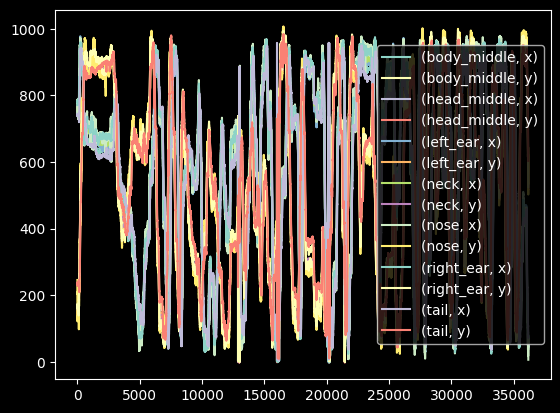

In [37]:
df_xy.plot().legend(loc='right')

In [38]:
df_flat = df_xy.copy()
df_flat.columns = df_flat.columns.map('_'.join)

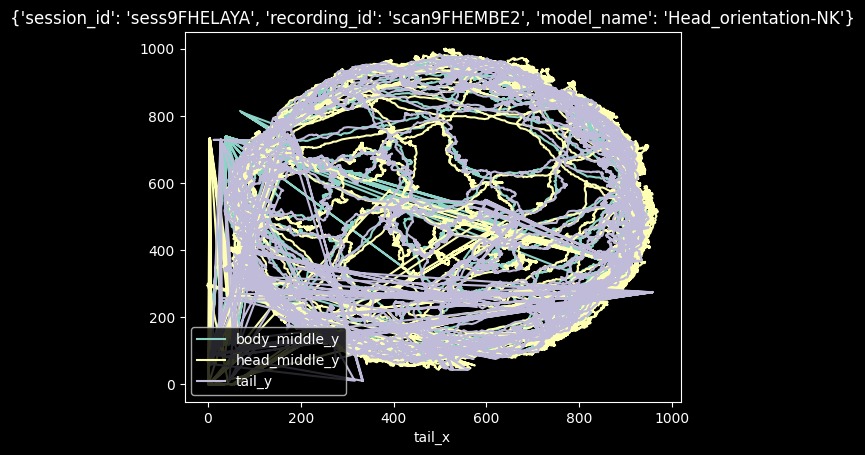

In [40]:
import matplotlib.pyplot as plt 
fig,ax=plt.subplots()
df_flat.plot(x='body_middle_x',y='body_middle_y',ax=ax)
df_flat.plot(x='head_middle_x',y='head_middle_y', ax=ax)
df_flat.plot(x='tail_x',y='tail_y', ax=ax)
plt.title(scan_key)
plt.show()

In [ ]:
destfolder = model.PoseEstimationTask.infer_output_dir(key)
destfolder

In [ ]:
from deeplabcut.utils.make_labeled_video import create_labeled_video

video_path = find_full_path( # Fetch the full video path
    get_dlc_root_data_dir(), ((model.VideoRecording.File & key).fetch1("file_path"))
)

config_paths = sorted( # Of configs in the project path, defer to the datajoint-saved
    list(
        find_full_path(
            get_dlc_root_data_dir(), ((model.Model & key).fetch1("project_path"))
        ).glob("*.y*ml")
    )
)

create_labeled_video( # Pass strings to label the video
    config=str(config_paths[-1]),
    videos=str(video_path),
    destfolder=str(destfolder),
)

# list(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).parent.glob("device*"))[0].glob("*.y*ml"))

In [ ]:
moviepath = str(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).glob("*53.mp4"))[0])
moviepath


In [ ]:
(model.VideoRecording.File & key).fetch1("file_path")

In [ ]:
list(list(pathlib.Path((model.VideoRecording.File & key).fetch1("file_path")).parent.glob("device*"))[0].glob("*.y*ml"))